# brunel_alpha_nest_topo.ipynb

**Modeling networks of spiking neurons using NEST**

**OCNC summer school 2018, 28.6.2018**

**Espen Hagen - espen.hagen@fys.uio.no**

Example adapted from ``nest/pynest/examples/brunel_alpha_nest.py``, based on a balanced random network originally described in:

[1] Brunel, N. Dynamics of Sparsely Connected Networks of Excitatory and Inhibitory Spiking Neurons. Journal of Computational Neuroscience. May 2000, Volume 8, Issue 3, pp 183-208.

Here, the example is further modified to set up populations as layers and connections between
neurons using NEST's ``topology`` library using exponential connectivity within a
mask and distance-dependent delays. 

This file is not part of NEST.
Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 2 of the License, or
(at your option) any later version.

NEST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with NEST.  If not, see <http://www.gnu.org/licenses/>.


In [1]:
# Import modules and functions
%pylab inline
from __future__ import division
import matplotlib.pyplot as plt
import nest
import nest.topology as topo
from time import time
from numpy import exp, log, random, pi, zeros_like, r_

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define helper function(s)
def ComputePSPnorm(tauMem, CMem, tauSyn):
    """
    Compute the maximum of postsynaptic potential
    for a synaptic input current of unit amplitude
    (1 pA)
    """
    a = tauMem / tauSyn
    b = 1.0 / tauSyn - 1.0 / tauMem
    # time of maximum
    t_max = 1.0/b * ( -nest.sli_func('LambertWm1',-exp(-1.0/a)/a) - 1.0/a )
    # maximum of PSP for current of unit amplitude
    return exp(1.0)/(tauSyn*CMem*b) * ((exp(-t_max/tauMem) - exp(-t_max/tauSyn)
                                        ) / b - t_max*exp(-t_max/tauSyn))

In [3]:
# Define main parameters for network and simulation

# tic - toc
startbuild = time()

# Simulation duration
dt      = 0.1    # Simulation resolution in ms
simtime = 500.0  # Simulation time in ms

# Parameters for asynchronous irregular firing
g       = 6.0    # relative inhibition factor
eta     = 2.0    # ratio between background rate and threshold rate
epsilon = 0.1    # connection probability

order   = 1000      # network size scaling factor
NE      = 4 * order # number of excitatory nodes
NI      = order     # number of inhibitory nodes

CE    = int(epsilon*NE)  # number of excitatory synapses per neuron
CI    = int(epsilon*NI)  # number of inhibitory synapses per neuron

In [4]:
# Initialize the parameters of the integrate and fire neuron
tauSyn = 0.5     # synapse time constant
tauMem = 20.     # membrane time constant
CMem = 250.      # membrane capacitance
theta  = 20.     # spike threshold (resting potential is 0 mV)
J      = 1.      # postsynaptic amplitude in mV

# Normalize synaptic current so that amplitude of a PSP is J
J_unit = ComputePSPnorm(tauMem, CMem, tauSyn)
J_ex  = J / J_unit
J_in  = -g * J_ex

# Threshold rate, equivalent rate of events needed to
# have mean input current equal to threshold
nu_th  = (theta * CMem) / (J_ex * CE * exp(1) * tauMem * tauSyn)
nu_ex  = eta * nu_th
p_rate = 1000. * nu_ex * CE   #Poisson rate

# Parameters for "iaf_psc_alpha" cell model
neuron_params= {"C_m" :        CMem,
                "tau_m" :      tauMem,
                "tau_syn_ex" : tauSyn,
                "tau_syn_in" : tauSyn,
                "t_ref" :      2.,
                "E_L" :        0.,
                "V_reset" :    0.,
                "V_th" :       20.,
                "V_m" :        0.,
                "V_th" :       theta,
               }

In [5]:
# Parameters for topology connections
extent_length = 4. # layer side length extent in mm
mask_radius = 2.   # mask radius in mm
tau = 0.3          # distance constant of exponential profile in mm

# Connection dictionary for topology connections, original implementation
# used fixed_indegree connectivity rule, here we use convergent connections
# and fixed number of connections
conn_dict_EX = {
    'connection_type': 'convergent',
    'allow_autapses': False,
    'allow_multapses': True,
    'weights' : J_ex,
    'delays' : {
        'linear' : {
            'c' : 1.5,
            'a' : 0.1
            }
        },
    'mask' : {
        'circular' : {'radius' : mask_radius}
        },
    'kernel' : {
        'exponential' : {
            'a' : 1.,
            'c' : 0.,
            'tau' : tau,
            }
        },
    'number_of_connections' : CE,
    }
conn_dict_IN = {
    'connection_type': 'convergent',
    'allow_autapses': False,
    'allow_multapses': True,
    'weights' : J_in,
    'delays' : {
        'linear' : {
            'c' : 1.5,
            'a' : 0.1
            }
        },
    'mask' : {
        'circular' : {'radius' : mask_radius}
        },
    'kernel' : {
        'exponential' : {
            'a' : 1.,
            'c' : 0.,
            'tau' : tau,
            }
        },
    'number_of_connections' : CI,}

In [6]:
# Layer-specific parameters for the excitatory and inhibitory populations
# including layer extent, cell positions, neuron model, periodic boundary flag
layerdict_EX = {
    'extent' : [extent_length, extent_length],
    'positions' : [[(random.rand()-0.5)*extent_length,
                    (random.rand()-0.5)*extent_length] for x in range(NE)],
    'elements' : 'iaf_psc_alpha',
    'edge_wrap' : True,}
layerdict_IN = {
    'extent' : [extent_length, extent_length],
    'positions' : [[(random.rand()-0.5)*extent_length,
                    (random.rand()-0.5)*extent_length] for x in range(NI)],
    'elements' : 'iaf_psc_alpha',
    'edge_wrap' : True,}

In [7]:
# Initialize NEST
nest.ResetKernel()

nest.SetKernelStatus({"resolution" : dt,
                      "print_time" : True,
                      "local_num_threads" : 4})

In [8]:
# Set some default parameters for IaF neuron, Poisson generator
nest.SetDefaults("iaf_psc_alpha", neuron_params)
nest.SetDefaults("poisson_generator", {"rate": p_rate})

In [9]:
# Create populations, generators and measurement devices

# Create excitatory and inhibitory layers
layer_ex = topo.CreateLayer(layerdict_EX)
layer_in = topo.CreateLayer(layerdict_IN)

# Expose node GIDs
nodes_ex = nest.GetChildren(layer_ex)[0]
nodes_in = nest.GetChildren(layer_in)[0]

print("first excitatory node: {}".format(layer_ex[0]))
print("first inhibitory node: {}".format(layer_in[0]))

# Distribute membrane potentials to reduce startup transient
nest.SetStatus(nodes_ex, "V_m",
               random.rand(len(nodes_ex))*neuron_params["V_th"])
nest.SetStatus(nodes_in, "V_m",
               random.rand(len(nodes_in))*neuron_params["V_th"])

# Create Poisson generator 
noise=nest.Create("poisson_generator")

# Create spike detectors for the different populations
espikes=nest.Create("spike_detector")
ispikes=nest.Create("spike_detector")

first excitatory node: 1
first inhibitory node: 4002


/opt/nest/lib/python3.6/site-packages/nest/lib/hl_api_helper.py:92: UserWarning: 
GetChilden is deprecated and will be removed in NEST 3.0. Use GIDCollection instead.
  warnings.warn('\n' + text)   # add LF so text starts on new line


In [10]:
# Connect the different devices and populations

# Copy static_synapse synapse model as excitatory and inhibitory,
# respectively, using the corresponding weights
nest.CopyModel("static_synapse", "excitatory", {"weight" : J_ex})
nest.CopyModel("static_synapse", "inhibitory", {"weight" : J_in})

# Connect Poisson generator
nest.Connect(noise, nodes_ex, 'all_to_all', "excitatory")
nest.Connect(noise, nodes_in,'all_to_all', "excitatory")

# Connect nodes to spike detector
nest.Connect(nodes_ex, espikes, 'all_to_all', "excitatory")
nest.Connect(nodes_in, ispikes, 'all_to_all', "excitatory")

# Connect the layers to each other using distance dependent
# connectivity, in the order of E-E, E-I, I-E and I-I, with fixed indegrees
topo.ConnectLayers(layer_ex, layer_ex, conn_dict_EX)
topo.ConnectLayers(layer_ex, layer_in, conn_dict_EX)

topo.ConnectLayers(layer_in, layer_ex, conn_dict_IN)
topo.ConnectLayers(layer_in, layer_in, conn_dict_IN)

#tic - toc
endbuild=time()

In [11]:
# Main simulation block, print out some statistics
print("Simulating")

nest.Simulate(simtime)

#tic - toc
endsimulate= time()

# Compute some statistics
events_ex = nest.GetStatus(espikes, "n_events")[0]
rate_ex   = events_ex / simtime*1000.0/len(nodes_ex)
events_in = nest.GetStatus(ispikes, "n_events")[0]
rate_in   = events_in / simtime * 1000.0 / len(nodes_in)

print("Brunel network simulation (Python)")
print("Number of neurons      : %i" % (NE + NI))
print("Number of exc. synapses: %i" % (int(CE * (NE + NI))))
print("Number of inh. synapses: %i" % (int(CI * (NE + NI))))
print("Excitatory rate        : %.2f Hz" % rate_ex)
print("Inhibitory rate        : %.2f Hz" % rate_in)
print("Building time          : %.2f s" % (endbuild - startbuild))
print("Simulation time        : %.2f s" % (endsimulate - endbuild))

Simulating
Brunel network simulation (Python)
Number of neurons      : 5000
Number of exc. synapses: 2000000
Number of inh. synapses: 500000
Excitatory rate        : 12.59 Hz
Inhibitory rate        : 12.88 Hz
Building time          : 34.69 s
Simulation time        : 8.48 s


Text(0,0.5,'x position (mm)')

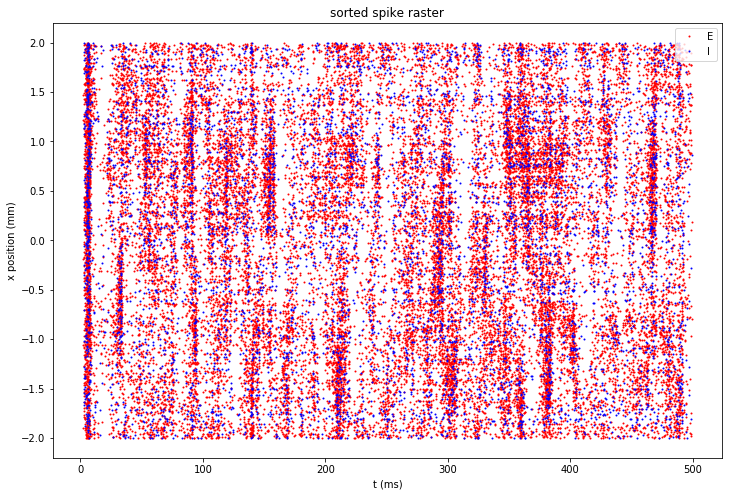

In [12]:
# Spike raster plot where units are sorted according to position along one axis
fig, ax = plt.subplots(1, figsize=(12, 8))

# Extract pairs of node and spike events
eevents = nest.GetStatus(espikes, 'events')[0]
ievents = nest.GetStatus(ispikes, 'events')[0]

# Plot excitatory spike trains
X = []
T = []
for i, j in enumerate(nodes_ex):
    t = eevents['times'][eevents['senders'] == j]
    x, y = layerdict_EX['positions'][i]
    if t.size > 0:
        T = r_[T, t]
        X = r_[X, zeros_like(t)+x]
ax.plot(T, X, 'r.', label='E', markersize=2)

# Plot inhibitory spike trains
X = []
T = []
for i, j in enumerate(nodes_in):
    t = ievents['times'][ievents['senders'] == j]
    x, y = layerdict_IN['positions'][i]
    if t.size > 0:
        T = r_[T, t]
        X = r_[X, zeros_like(t)+x]
ax.plot(T, X, 'b.', label='I', markersize=2)

# Annotate
ax.axis()
ax.legend(loc=1)
ax.set_title('sorted spike raster')
ax.set_xlabel('t (ms)')
ax.set_ylabel('x position (mm)')